In [21]:
from sklearn.cluster import KMeans
import numpy as np
import nsepy
import datetime
import ta
import pandas as pd
from pandas_datareader import data
import random

In [22]:
#X=pd.read_csv('NSEI.csv')

In [23]:
#X

In [24]:
def data_preprocessing():
    X=pd.read_csv('DJI.csv')
 
    X['c-o']=(X.Close-X.Open)/X.Open*100
    X['candle']=np.where(X['c-o'].values<-2,0,np.where(X['c-o'].values<-1,1,np.where(X['c-o'].values<0,2,np.where(X['c-o'].values<1,3,np.where(X['c-o'].values<2,4,5))))) #This line updates the value of candle column based on the value of corresponding c-o. If c-o <2 it is 4 else it is 5. if c-o<1 it is 3 else it goes to previous condition and so on.
   
    X = X.dropna(axis = 0, how ='any') #drop rows with missing values meaning if row has 'any ' empty values drop it
    X = X.reset_index()

    X = X.reset_index()
    X['cash']=0
    X['action']=""
    X['action1']=""
    return X


In [25]:
X=data_preprocessing()
X

,level_0,index,Date,High,Low,Open,Close,Volume,Adj Close,c-o,candle,cash,action,action1
0,0,0,2000-10-19,10142.980469,10014.610352,10014.610352,10142.980469,343710000,10142.980469,1.281828,4,0,,
1,1,1,2000-10-20,10229.549805,10067.509766,10141.129883,10226.589844,319750000,10226.589844,0.842707,3,0,,
2,2,2,2000-10-23,10361.250000,10216.230469,10230.290039,10271.719727,339180000,10271.719727,0.404971,3,0,,
3,3,3,2000-10-24,10439.309570,10273.570312,10273.570312,10393.070312,274990000,10393.070312,1.163179,4,0,,
4,4,4,2000-10-25,10461.969727,10306.589844,10395.660156,10326.480469,312490000,10326.480469,-0.665467,2,0,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4572,4572,4572,2018-12-24,22339.869141,21792.199219,22317.279297,21792.199219,308420000,21792.199219,-2.352796,0,0,,
4573,4573,4573,2018-12-26,22878.919922,21712.529297,21857.730469,22878.449219,433080000,22878.449219,4.669830,5,0,,
4574,4574,4574,2018-12-27,23138.890625,22267.419922,22629.060547,23138.820312,407940000,23138.820312,2.252678,5,0,,
4575,4575,4575,2018-12-28,23381.880859,22981.330078,23213.609375,23062.400391,336510000,23062.400391,-0.651381,2,0,,


Populating the interactive namespace from numpy and matplotlib


c:\python\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


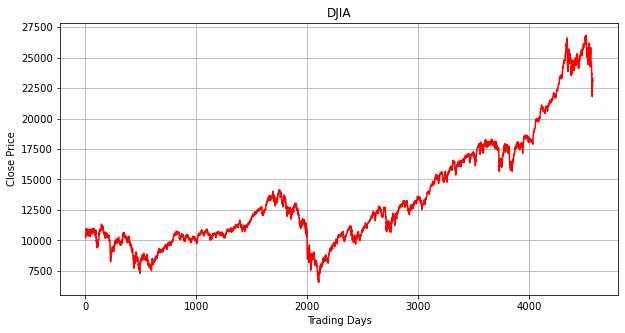

In [26]:
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('pylab', 'inline')
fig = plt.figure()
ax=X.loc[1:4577,'Close'].plot(grid="True",figsize=(10,5), title='DJIA',color="r")
ax.set_xlabel("Trading Days")
ax.set_ylabel("Close Price")
plt.savefig("IMAGES/DJIA.png")
plt.show()


In [29]:
def getState(t):    
    return(X['candle'][t])   #It returns the value of candle entry which was based on the open and close price -basically on of the 6 states


In [30]:
X.loc[1,'Open']*100

1014112.98828125

In [31]:
class Training_Agent:
    def __init__(self):
        self.epsilon = 1.0 #Value of  epsilon to denote we are exploring as much as possible
        self.gamma = 0.618 #Discount factor decided as 0.618
        self.epsilon_decay = 0.995 #rate at which epsilon decays as we reach optimal solution.
        self.epsilon_min = 0.01 #minimum value epsilon should take
        self.Q = np.matrix(np.zeros([6,3])) #6 states and 3 actions for each state initial Q table entries are zero.
        self.learning_rate=0.03 #parameter used in Q-learning equation.
        
    def obtainAction(self,state):
        a=[1,0,2]
        if np.random.rand() <= self.epsilon: #compares random numbers between -1 to 1 to epsilon value at that point of time.
            return random.choice(a) #if true, choose a random value of a.
        return np.argmax(self.Q[state,])  #else, choose the action with highest state value 1-epsilon times(acc to epsilon greedy algo)
    
    # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
    def updateQtable(self,state,action,reward,next_state,next_action):
            self.Q[state,action]= self.Q[state,action] + self.learning_rate * (reward + self.gamma * np.max(self.Q[next_state, :])
                                                                - self.Q[state,action])


In [42]:
episodes=200  #no.of episodes
agent=Training_Agent()   #calling the agent
m1=0 
m2=0
overall_profit=0
for e in range(1,episodes+1):   #running loop for episode number of times
    data_djia =data_preprocessing()  #updated data entry   
    data_length_start=1
    data_length_end=1305
    agent.epsilon=1
    state = getState(data_length_start) #get state X['candle'][1] always here meaning initial state is always 3 initially.
    action = agent.obtainAction(state) #based on that state, we select action of state 3 having max.reward 1-epsilon times and random action e times.
    last_action=None #for first state of the episode last action NULL.
    last_price=0
    last_quantity=0
    capital=data_djia.loc[data_length_start,'Open']*100 #Initial capital at start of episode. based on the entry at 1st  row.
    margin=data_djia.loc[data_length_start,'Open']*100  #initial margin
    broker_rate=0.0010 
    total_profit=0    #no profit at start of episode.
    print("Episod {}/{}".format(e,episodes))
    count_pos=0
    for i in range(data_length_start,data_length_end):  #variable t in train data.     
        reward=0   #setting reward to zero each time
        if last_action=='sold':  #if previous action was sell, we update profit and brokerage for previous day
            totbrokerage=(data_djia.loc[i,'Open']+last_price)*broker_rate 
            currprofit=(last_price-data_djia.loc[i,'Open'])*last_quantity
            totprofit1=(currprofit/(last_price*last_quantity))*100
            
            if totprofit1<-10:   #if profit is below 10%, we will stop short as we incurred a huge loss. Hence close short
                total_profit=total_profit+currprofit
                margin=margin+(last_quantity*last_price)+(currprofit)
                data_djia.loc[i,'cash']=margin     
                last_action=None
                data_djia.loc[i,'action']="close short"
                data_djia.loc[i,'action1']="long"
                reward= max((np.log(last_price)-np.log(data_djia.loc[i,'Open'])),0)

        elif last_action=='bought':   #if last action is bought, then again we update variables for previous day
            totbrokerage=(data_djia.loc[i,'Open']+last_price)*broker_rate
            currprofit=(data_djia.loc[i,'Open']-last_price)*last_quantity
            totprofit1=(currprofit/(last_price*last_quantity))*100

            if totprofit1<-10:   #if profit upon buying is less than 10% then we close long
                total_profit=total_profit+currprofit
                margin=margin+(last_quantity*last_price)+(currprofit)
                data_djia.loc[i,'cash']=margin        
                last_action=None
                data_djia.loc[i,'action']="close long"
                data_djia.loc[i,'action1']="short"
                reward= max((np.log(data_djia.loc[i,'Open'])-np.log(last_price)),0)               
                          
            
        if action == 1  and last_action==None :  #if no previous action then we should open long for action = 1
            data_djia.loc[i,'cash']=margin            
            last_quantity=margin//data_djia.loc[i,'Open']
            margin=margin%data_djia.loc[i,'Open']
            last_action='bought'   #Since we bought now as we opened long, last action is bought
            last_price=data_djia.loc[i,'Open']  #last price becomes open price currently
            data_djia.loc[i,'action']="open long"
            data_djia.loc[i,'action1']="long"
            count_pos+=1

        elif action == 1  and last_action=='sold':  #If action is 1 and sold was happening before, then we close short
            totbrokerage=(data_djia.loc[i,'Open']+last_price)*broker_rate
            currprofit=(last_price-data_djia.loc[i,'Open']-totbrokerage)*last_quantity
            totprofit1=(currprofit/(last_price*last_quantity))*100

            if totprofit1>10 or totprofit1<-5:   #close short if this does not happen
                total_profit=total_profit+currprofit
                margin=margin+(last_quantity*last_price)+(currprofit)
                data_djia.loc[i,'cash']=margin      
                data_djia.loc[i,'action']="close short"
                data_djia.loc[i,'action1']="long"
                last_action=None
                reward= max((np.log(last_price)-np.log(data_djia.loc[i,'Open']+totbrokerage)),0)

            else:
                prof_tot=(last_price-data_djia.loc[i,'Close'])*last_quantity  #Calculating total profit  #tp
                original=margin+(last_quantity*last_price)
                data_djia.loc[i,'cash']=original+prof_tot  
                
        elif action == 1  and last_action=='bought':  #If action is 1 and we bought (long), then we continue or hold long position
            data_djia.loc[i,'cash']=margin+(last_quantity*data_djia.loc[i,'Close'])

        elif action == 2  and last_action==None and margin>data_djia.loc[i,'Open']:    #If action is 2 and we did nothing then we start short( open short ). But if our margin is less than open, then we dont
            data_djia.loc[i,'cash']=margin        
            last_quantity=margin//data_djia.loc[i,'Open']
            margin=margin%data_djia.loc[i,'Open']
            last_price=data_djia.loc[i,'Open']
            last_action='sold'        
            data_djia.loc[i,'action']="open short"
            data_djia.loc[i,'action1']="short"      
            count_pos+=1

        elif action == 2  and last_action=='sold':    #If action is 2 and last action was sold(short), then we continue in short(hold)
            prof_tot=(last_price-data_djia.loc[i,'Close'])*last_quantity
            original=margin+(last_quantity*last_price)
            data_djia.loc[i,'cash']=original+prof_tot

        elif action == 2 and  last_action=='bought':  #If action is 2 and last action was bought then we close long 
            totbrokerage=(data_djia.loc[i,'Open']+last_price)*broker_rate
            currprofit=(data_djia.loc[i,'Open']-last_price-totbrokerage)*last_quantity
            totprofit1=(currprofit/(last_price*last_quantity))*100

            if totprofit1>10 or totprofit1<-5:
              total_profit=total_profit+currprofit 
              margin=margin+(last_quantity*last_price)+currprofit
              data_djia.loc[i,'cash']=margin        
              last_action=None
              data_djia.loc[i,'action']="close long"
              data_djia.loc[i,'action1']="short"
              reward= max((np.log(data_djia.loc[i,'Open'])-np.log(last_price+totbrokerage)),0) 

            else:
              data_djia.loc[i,'cash']=margin+(last_quantity*data_djia.loc[i,'Close'])

        else:            
            if last_action==None:   #if no last action then we just stay in that current position
                data_djia.loc[i,'cash']=margin 
            elif last_action=='bought':
                data_djia.loc[i,'cash']=margin+(last_quantity*data_djia.loc[i,'Close']) 
            elif last_action=='sold':
                prof_tot=(last_price-data_djia.loc[i,'Close'])*last_quantity
                original=margin+(last_quantity*last_price)
                data_djia.loc[i,'cash']=original+prof_tot
                                       
              
        next_state=getState(i+1)   #we get the next state every time
        next_action=agent.obtainAction(next_state)   #we get the next action every time
        agent.updateQtable(state,action,reward,next_state,next_action)   #Here we update the Qtable
        state=next_state     
        action=next_action
        
        if i==data_length_end-2:  #We are in the last but one row for that particular episode, we print results of that episode after predicting last row stock
                print("--------------------------------\n")

                if  last_action=='sold':  #we calculate profit and close short
                    totbrokerage=(data_djia.loc[i,'Close']+last_price)*broker_rate
                    currprofit=(last_price-data_djia.loc[i,'Close']-totbrokerage)*last_quantity
                    total_profit=total_profit+currprofit
                    margin=margin+(last_quantity*last_price)+(currprofit) 
                    data_djia.loc[i,'cash']=margin
                    last_action=None
                    data_djia.loc[i,'action']="close short"
                    data_djia.loc[i,'action1']="long"

                elif last_action=='bought':  #we calculate profit and close long
                    totbrokerage=(data_djia.loc[i,'Close']+last_price)*broker_rate
                    currprofit=(data_djia.loc[i,'Close']-last_price-totbrokerage)*last_quantity
                    total_profit=total_profit+currprofit
                    margin=margin+(last_quantity*last_price)+(currprofit) 
                    data_djia.loc[i,'cash']=margin
                    last_action=None
                    data_djia.loc[i,'action']="close long"
                    data_djia.loc[i,'action1']="short"
                print("***********************\n")
                print("Total Profit is ",total_profit)  #printing profit
                maxprofit=total_profit  #printing maxprofit
                overall_profit+=total_profit   #printing overall profit or loss obtained
                print("Initial Capital is ",capital)    
                print("Current Capital is ",margin)
                roi=((margin-capital)/capital)*100  #return of interest
                print("Percentage Return of Interest is ",roi)
                buyandhold=((data_djia.loc[i,'Close']-data_djia.loc[data_length_start,'Close'])/data_djia.loc[data_length_start,'Close'])*100
                print("% Buy and Hold=",buyandhold)  
                print("Total count of changing states is",count_pos)
                print("The Qtable is ",agent.Q)
                print("The final value of Epsilon",agent.epsilon)
                print("--------------------------------")
                       
        if (agent.epsilon > agent.epsilon_min) and e>1:   
                       agent.epsilon *= agent.epsilon_decay
                      
    
    
    m3=roi
    if m3>m2:
        m1=e
        m2=m3
  #  #To save model            
   # np.save('C:\Python\RL PROJECT CODE\MODEL2-TRAINING\Qtable/Qtable'+ str(e)+str('.npy'), agent.Q)
   # np.save('C:\Python\RL PROJECT CODE\MODEL2-TRAINING\Epsilon/epsilon'+ str(e)+str('.npy'), agent.epsilon)
   # np.save('C:\Python\RL PROJECT CODE\MODEL2-TRAINING\Gamma/gamma'+ str(e)+str('.npy'), agent.gamma)
   # np.save('C:\Python\RL PROJECT CODE\MODEL2-TRAINING\Learning_Rate/learning_rate'+ str(e)+str('.npy'), agent.learning_rate)
   # X.to_csv('C:\Python\RL PROJECT CODE\MODEL2-TRAINING\AfterTrain/AfterTrain'+str(e)+str('.csv'))
#print("e={},roi={}".format(m1,m2))

Episod 1/200
--------------------------------

***********************

Total Profit is  -63627.52044873044
Initial Capital is  1014112.98828125
Current Capital is  950485.4678325199
Percentage Return of Interest is  -6.2742042734871175
% Buy and Hold= 5.570477848225769
Total count of changing states is 19
The Qtable is  [[0.0002259  0.00622391 0.00035358]
 [0.0007973  0.00076321 0.0007823 ]
 [0.00074607 0.00066644 0.00072915]
 [0.00064027 0.00064434 0.00066856]
 [0.00083844 0.00219728 0.00050863]
 [0.00050779 0.00461684 0.00041341]]
The final value of Epsilon 1
--------------------------------
Episod 2/200
--------------------------------

***********************

Total Profit is  823530.292665527
Initial Capital is  1014112.98828125
Current Capital is  1837643.2809467774
Percentage Return of Interest is  81.20695644193178
% Buy and Hold= 5.570477848225769
Total count of changing states is 21
The Qtable is  [[0.00050478 0.00765177 0.0003923 ]
 [0.00176306 0.00106333 0.00106998]
 [0.00

--------------------------------

***********************

Total Profit is  231323.87738916013
Initial Capital is  1014112.98828125
Current Capital is  1245436.8656704095
Percentage Return of Interest is  22.81046392879894
% Buy and Hold= 5.570477848225769
Total count of changing states is 18
The Qtable is  [[0.00105673 0.00972416 0.00113012]
 [0.00124453 0.00156677 0.00241017]
 [0.000675   0.00067782 0.00067821]
 [0.00062017 0.00061881 0.00062419]
 [0.00089025 0.00106144 0.00105506]
 [0.00121627 0.0044289  0.00097401]]
The final value of Epsilon 0.00998645168764533
--------------------------------
Episod 16/200
--------------------------------

***********************

Total Profit is  24510.811406249944
Initial Capital is  1014112.98828125
Current Capital is  1038623.7996874999
Percentage Return of Interest is  2.4169704647794283
% Buy and Hold= 5.570477848225769
Total count of changing states is 20
The Qtable is  [[0.00127785 0.00738646 0.00108954]
 [0.00134305 0.00154761 0.00260008

--------------------------------

***********************

Total Profit is  37438.024446777476
Initial Capital is  1014112.98828125
Current Capital is  1051551.0127280278
Percentage Return of Interest is  3.6917015046054074
% Buy and Hold= 5.570477848225769
Total count of changing states is 22
The Qtable is  [[0.00116842 0.00725965 0.00098417]
 [0.00143642 0.00143906 0.00119568]
 [0.00055016 0.00054843 0.00055369]
 [0.00052917 0.00052938 0.00053395]
 [0.00092732 0.00101059 0.00099937]
 [0.00114135 0.00413979 0.00126879]]
The final value of Epsilon 0.00998645168764533
--------------------------------
Episod 30/200
--------------------------------

***********************

Total Profit is  182781.39181347663
Initial Capital is  1014112.98828125
Current Capital is  1196894.3800947266
Percentage Return of Interest is  18.023769927575835
% Buy and Hold= 5.570477848225769
Total count of changing states is 21
The Qtable is  [[0.00120491 0.00655125 0.00105945]
 [0.00131868 0.00150199 0.0011984

--------------------------------

***********************

Total Profit is  169262.8487539062
Initial Capital is  1014112.98828125
Current Capital is  1183375.8370351559
Percentage Return of Interest is  16.690728815215923
% Buy and Hold= 5.570477848225769
Total count of changing states is 24
The Qtable is  [[0.0010246  0.00311695 0.00361522]
 [0.00161262 0.0015114  0.00274254]
 [0.00088372 0.00089286 0.00088738]
 [0.00082166 0.00082632 0.00082336]
 [0.00133907 0.00106595 0.00106882]
 [0.00141262 0.00664455 0.00149834]]
The final value of Epsilon 0.00998645168764533
--------------------------------
Episod 44/200
--------------------------------

***********************

Total Profit is  1275327.904145508
Initial Capital is  1014112.98828125
Current Capital is  2289440.8924267576
Percentage Return of Interest is  125.75796966243107
% Buy and Hold= 5.570477848225769
Total count of changing states is 20
The Qtable is  [[0.00112527 0.00316906 0.00297794]
 [0.00165789 0.0023542  0.0021138 ]

--------------------------------

***********************

Total Profit is  557613.0505317382
Initial Capital is  1014112.98828125
Current Capital is  1571726.0388129887
Percentage Return of Interest is  54.98529818425839
% Buy and Hold= 5.570477848225769
Total count of changing states is 17
The Qtable is  [[0.0013695  0.00718247 0.0017191 ]
 [0.00100817 0.00161762 0.0009432 ]
 [0.00048721 0.00049166 0.00049199]
 [0.00050421 0.00049876 0.00050339]
 [0.00080707 0.00118412 0.00077498]
 [0.0015677  0.00770414 0.00165872]]
The final value of Epsilon 0.00998645168764533
--------------------------------
Episod 58/200
--------------------------------

***********************

Total Profit is  -436412.3864370116
Initial Capital is  1014112.98828125
Current Capital is  577700.601844238
Percentage Return of Interest is  -43.0339016934057
% Buy and Hold= 5.570477848225769
Total count of changing states is 22
The Qtable is  [[0.00147275 0.00556083 0.00176223]
 [0.00102932 0.00102983 0.0010184 ]
 [

--------------------------------

***********************

Total Profit is  -224145.05910742184
Initial Capital is  1014112.98828125
Current Capital is  789967.9291738281
Percentage Return of Interest is  -22.102572563172657
% Buy and Hold= 5.570477848225769
Total count of changing states is 21
The Qtable is  [[0.00142167 0.00620957 0.00140492]
 [0.00126997 0.00112984 0.00197755]
 [0.00062414 0.00062989 0.00063012]
 [0.00060083 0.00059749 0.00059899]
 [0.00100151 0.00096642 0.00097661]
 [0.00130907 0.00297117 0.00132335]]
The final value of Epsilon 0.00998645168764533
--------------------------------
Episod 72/200
--------------------------------

***********************

Total Profit is  530834.8682636719
Initial Capital is  1014112.98828125
Current Capital is  1544947.8565449216
Percentage Return of Interest is  52.34474603893467
% Buy and Hold= 5.570477848225769
Total count of changing states is 19
The Qtable is  [[0.00139229 0.00335744 0.00140673]
 [0.00132049 0.00114122 0.0023621 

--------------------------------

***********************

Total Profit is  -426825.36829931656
Initial Capital is  1014112.98828125
Current Capital is  587287.6199819339
Percentage Return of Interest is  -42.08854173366944
% Buy and Hold= 5.570477848225769
Total count of changing states is 22
The Qtable is  [[0.00137414 0.00172176 0.00170443]
 [0.00091709 0.00096008 0.00240454]
 [0.00053449 0.00052808 0.00053376]
 [0.00048749 0.00049136 0.00048776]
 [0.00089899 0.00089108 0.00090232]
 [0.00136274 0.004126   0.0016448 ]]
The final value of Epsilon 0.00998645168764533
--------------------------------
Episod 86/200
--------------------------------

***********************

Total Profit is  -63248.37232031251
Initial Capital is  1014112.98828125
Current Capital is  950864.6159609379
Percentage Return of Interest is  -6.236817105311645
% Buy and Hold= 5.570477848225769
Total count of changing states is 24
The Qtable is  [[0.00133462 0.00230401 0.00151221]
 [0.00098025 0.00122102 0.00131225

--------------------------------

***********************

Total Profit is  -42176.36911914065
Initial Capital is  1014112.98828125
Current Capital is  971936.6191621092
Percentage Return of Interest is  -4.158941814819135
% Buy and Hold= 5.570477848225769
Total count of changing states is 20
The Qtable is  [[0.00161492 0.00582711 0.00141839]
 [0.00120914 0.00110984 0.00124745]
 [0.00072259 0.00071612 0.00072206]
 [0.00063145 0.00063624 0.00063385]
 [0.00108342 0.00111872 0.0035737 ]
 [0.00170415 0.00192403 0.00121182]]
The final value of Epsilon 0.00998645168764533
--------------------------------
Episod 100/200
--------------------------------

***********************

Total Profit is  -130103.4328173828
Initial Capital is  1014112.98828125
Current Capital is  884009.5554638674
Percentage Return of Interest is  -12.829283750510475
% Buy and Hold= 5.570477848225769
Total count of changing states is 23
The Qtable is  [[0.00163828 0.00538302 0.00138618]
 [0.00120177 0.0010988  0.0011910

--------------------------------

***********************

Total Profit is  -274369.74577050784
Initial Capital is  1014112.98828125
Current Capital is  739743.2425107423
Percentage Return of Interest is  -27.055145623912974
% Buy and Hold= 5.570477848225769
Total count of changing states is 20
The Qtable is  [[0.00134257 0.0043328  0.00140332]
 [0.00097647 0.00096926 0.00098679]
 [0.00060991 0.0006128  0.00061188]
 [0.00053607 0.00053325 0.00053074]
 [0.00095814 0.00096976 0.00175584]
 [0.00135333 0.00249974 0.00152825]]
The final value of Epsilon 0.00998645168764533
--------------------------------
Episod 114/200
--------------------------------

***********************

Total Profit is  47896.77947509767
Initial Capital is  1014112.98828125
Current Capital is  1062009.7677563475
Percentage Return of Interest is  4.723021993463912
% Buy and Hold= 5.570477848225769
Total count of changing states is 22
The Qtable is  [[0.00135438 0.00255101 0.00129558]
 [0.00095733 0.00130403 0.0011179

--------------------------------

***********************

Total Profit is  -302872.25911083975
Initial Capital is  1014112.98828125
Current Capital is  711240.7291704101
Percentage Return of Interest is  -29.865731196694085
% Buy and Hold= 5.570477848225769
Total count of changing states is 23
The Qtable is  [[0.00131713 0.00576324 0.00254768]
 [0.00109034 0.00105117 0.00106264]
 [0.00061219 0.00068081 0.00084631]
 [0.00057802 0.00061279 0.00058062]
 [0.00085546 0.00079318 0.00157095]
 [0.00129344 0.00495001 0.00116091]]
The final value of Epsilon 0.00998645168764533
--------------------------------
Episod 128/200
--------------------------------

***********************

Total Profit is  719347.0869218751
Initial Capital is  1014112.98828125
Current Capital is  1733460.075203125
Percentage Return of Interest is  70.9336232978385
% Buy and Hold= 5.570477848225769
Total count of changing states is 23
The Qtable is  [[0.00133959 0.01105014 0.00251713]
 [0.00116108 0.00104803 0.00194753]

--------------------------------

***********************

Total Profit is  -455001.02358984365
Initial Capital is  1014112.98828125
Current Capital is  559111.9646914061
Percentage Return of Interest is  -44.86689637621087
% Buy and Hold= 5.570477848225769
Total count of changing states is 24
The Qtable is  [[0.0013799  0.00140036 0.0013783 ]
 [0.00096141 0.00141087 0.00100695]
 [0.00050872 0.00050464 0.0005032 ]
 [0.00048888 0.00048605 0.00048565]
 [0.00089596 0.00089984 0.00084982]
 [0.00127034 0.00215035 0.00215986]]
The final value of Epsilon 0.00998645168764533
--------------------------------
Episod 142/200
--------------------------------

***********************

Total Profit is  -580363.7579726563
Initial Capital is  1014112.98828125
Current Capital is  433749.23030859395
Percentage Return of Interest is  -57.22870771591975
% Buy and Hold= 5.570477848225769
Total count of changing states is 21
The Qtable is  [[0.00120419 0.00118343 0.00118559]
 [0.00082366 0.00082558 0.000821

--------------------------------

***********************

Total Profit is  -521522.3767060546
Initial Capital is  1014112.98828125
Current Capital is  492590.6115751953
Percentage Return of Interest is  -51.42645668999338
% Buy and Hold= 5.570477848225769
Total count of changing states is 24
The Qtable is  [[0.00131136 0.00201927 0.0012693 ]
 [0.00110004 0.00172058 0.00107539]
 [0.00064765 0.00065234 0.00065275]
 [0.00057074 0.0005676  0.00056619]
 [0.00092432 0.00100863 0.00102615]
 [0.00137992 0.00159512 0.00167484]]
The final value of Epsilon 0.00998645168764533
--------------------------------
Episod 156/200
--------------------------------

***********************

Total Profit is  -163958.61173632814
Initial Capital is  1014112.98828125
Current Capital is  850154.3765449217
Percentage Return of Interest is  -16.167686799299403
% Buy and Hold= 5.570477848225769
Total count of changing states is 24
The Qtable is  [[0.00131649 0.0041452  0.00121898]
 [0.00100312 0.00099675 0.001007

--------------------------------

***********************

Total Profit is  401589.7488847654
Initial Capital is  1014112.98828125
Current Capital is  1415702.7371660157
Percentage Return of Interest is  39.600099153191245
% Buy and Hold= 5.570477848225769
Total count of changing states is 24
The Qtable is  [[0.00147245 0.00715148 0.00150761]
 [0.00114794 0.00126681 0.00282686]
 [0.00073251 0.00072902 0.00072627]
 [0.00075404 0.00074735 0.00075527]
 [0.00111916 0.00108298 0.00128423]
 [0.00147692 0.00265971 0.00145749]]
The final value of Epsilon 0.00998645168764533
--------------------------------
Episod 170/200
--------------------------------

***********************

Total Profit is  -430294.89470654295
Initial Capital is  1014112.98828125
Current Capital is  583818.093574707
Percentage Return of Interest is  -42.43066597892805
% Buy and Hold= 5.570477848225769
Total count of changing states is 20
The Qtable is  [[0.00149957 0.00506077 0.00146812]
 [0.00103747 0.00107908 0.00103772

--------------------------------

***********************

Total Profit is  208711.69428320313
Initial Capital is  1014112.98828125
Current Capital is  1222824.6825644532
Percentage Return of Interest is  20.58071405208351
% Buy and Hold= 5.570477848225769
Total count of changing states is 20
The Qtable is  [[0.0016468  0.00711829 0.00142242]
 [0.00127401 0.00168129 0.00133508]
 [0.00108185 0.00104849 0.00108311]
 [0.00095011 0.00095735 0.00095428]
 [0.00139459 0.00114675 0.00141218]
 [0.00169294 0.00138608 0.00439558]]
The final value of Epsilon 0.00998645168764533
--------------------------------
Episod 184/200
--------------------------------

***********************

Total Profit is  -193267.38190283207
Initial Capital is  1014112.98828125
Current Capital is  820845.6063784178
Percentage Return of Interest is  -19.057776020637277
% Buy and Hold= 5.570477848225769
Total count of changing states is 26
The Qtable is  [[0.00166198 0.00395693 0.0014602 ]
 [0.0013995  0.00208216 0.001438

--------------------------------

***********************

Total Profit is  -184337.84110888676
Initial Capital is  1014112.98828125
Current Capital is  829775.1471723636
Percentage Return of Interest is  -18.1772488114276
% Buy and Hold= 5.570477848225769
Total count of changing states is 23
The Qtable is  [[0.00146585 0.00207848 0.00127457]
 [0.00118431 0.00127174 0.00128138]
 [0.00054499 0.00054442 0.00054296]
 [0.00051156 0.0005074  0.00050826]
 [0.00091614 0.00091606 0.00091985]
 [0.00123515 0.0070741  0.00137889]]
The final value of Epsilon 0.00998645168764533
--------------------------------
Episod 198/200
--------------------------------

***********************

Total Profit is  570451.6991459964
Initial Capital is  1014112.98828125
Current Capital is  1584564.6874272465
Percentage Return of Interest is  56.25129603288246
% Buy and Hold= 5.570477848225769
Total count of changing states is 22
The Qtable is  [[0.0015652  0.00368175 0.00127457]
 [0.00119847 0.00228387 0.00123856]

In [43]:
agent.Q #Q-table used for action selection

matrix([[0.0014363 , 0.00416257, 0.00118092],
        [0.0010005 , 0.00100773, 0.00100159],
        [0.00053974, 0.00054385, 0.00054567],
        [0.00051985, 0.00051584, 0.00051652],
        [0.00099985, 0.00100555, 0.00084596],
        [0.001412  , 0.00408189, 0.00153571]])

Populating the interactive namespace from numpy and matplotlib


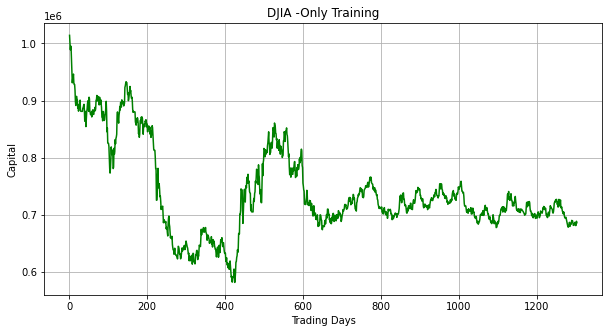

In [45]:
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('pylab', 'inline')
fig = plt.figure()
ax=data_djia.loc[data_length_start:data_length-2,'cash'].plot(grid="True",figsize=(10,5), title='DJIA -Only Training',color="g")
ax.set_xlabel("Trading Days")
ax.set_ylabel("Capital")
plt.savefig("IMAGES/Train.png")
plt.show()

